# ISIC Challenge Lesion Segmentation Using Progressive Neural Network


*Neuro Data Design II: Spring 2022*

This tutorial describes how to use ProgLearn to perform scene segmentation on the International Skin Imaging Collaboration Challenge Dataset, a skin lesion dataset containing 900 images of skin lesion for the purpose of training machine learning models on for lesion segmentation.

**Contributor**: Kevin Rao (experiment), Narayani Wagle (voter class)

## 0. Imports and Setup

Import needed modules and functions.

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from functions.isic_proglearn_nn_functions import UNet, dice
from sklearn.model_selection import KFold
from tensorflow.keras.backend import clear_session
from proglearn.transformers import NeuralClassificationTransformer
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.voters import MLKNNClassificationVoter
from proglearn.deciders import BinaryRoundDecider
from tensorflow.keras.optimizers import Adam, SGD
from proglearn.deciders import SimpleArgmaxAverage
from tensorflow.keras.callbacks import EarlyStopping

Set random seed for reproducibility.

In [2]:
seed = 0
random.seed = seed
np.random.seed = seed
tf.seed = seed

## 1. Data Extraction and Preprocessing

Load the images from the ISIC Dataset.

In [3]:
image_size = 128
path = "./"
train_path = "./ISIC2018_Task1-2_Training_Input"

## Training Ids
train_ids = []
for files in os.walk(train_path):
    for name in files:
        train_ids.append(name)

train_ids = train_ids[2]
ids = [i.split(".", 1)[0] for i in train_ids]


def get_images(data_path, ids, image_size):
    images = np.zeros((len(ids), image_size, image_size, 3))
    masks = np.zeros((len(ids), image_size, image_size, 1))

    for i, id_name in enumerate(ids):
        image_path = (
            os.path.join(data_path, "ISIC2018_Task1-2_Training_Input", id_name) + ".jpg"
        )
        mask_path = (
            os.path.join(data_path, "ISIC2018_Task1_Training_GroundTruth", id_name)
            + "_segmentation.png"
        )
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (image_size, image_size))
        mask = np.zeros((image_size, image_size, 1))
        _mask = cv2.imread(mask_path, -1)
        _mask = cv2.resize(_mask, (image_size, image_size))
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)

        ## Normalizaing
        images[i, :, :, :] = image / 255.0
        masks[i, :, :, :] = np.rint(mask / 255.0)
    return images, masks

Visualize a sample image.

In [4]:
x, y = get_images(path, ids[:20], image_size)

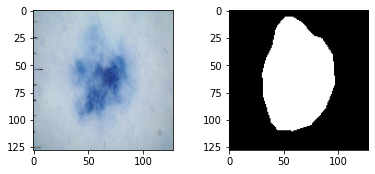

In [5]:
r = random.randint(0, len(x) - 1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(np.rint(y[r]), (image_size, image_size)), cmap="gray")

## 2. Hyperparameters

Below are the configurable hyperparameters.
- `num_tasks`: number of tasks for experiment (number of trials is one more than `num_tasks`)
- `batch_size`: number of datapoints per task
- `network_batch_size`: number of datapoints per batch for transformer training
- `test_batch_size`: number of testing datapoints
- `transformer_epochs`: number of transformer training epochs
- `k_neighbors`: number of neighbors in clustering for voter

In [8]:
# hyperparameters

num_tasks = 4
batch_size = 50
network_batch_size = 10
test_batch_size = batch_size // num_tasks
transformer_epochs = 25
k_neighbors = 3

## 3. Training

In [ ]:
accuracies = np.full((num_tasks + 1, num_tasks, num_tasks + 1), np.nan)

random.shuffle(ids)

data_ids = ids[: (num_tasks + 1) * batch_size]
kf = KFold(n_splits=num_tasks + 1)
for i, (train_index, test_index) in enumerate(kf.split(data_ids)):
    train_ids = [data_ids[i] for i in train_index]
    test_ids = [data_ids[i] for i in test_index]

    for task in range(num_tasks):
        print(f"Experiment {i} Task {task}")
        clear_session()

        network = UNet()
        transformer = NeuralClassificationTransformer

        kwargs = {
            "network": network,
            "euclidean_layer_idx": -2,
            "loss": "categorical_crossentropy",
            "optimizer": SGD(),
            "categorical": False,
            "fit_kwargs": {
                "epochs": transformer_epochs,
                "callbacks": [EarlyStopping(patience=5, monitor="val_loss")],
                "verbose": False,
                "shuffle": True,
                "validation_split": 0.33,
                "batch_size": network_batch_size,
            },
        }
        voter = MLKNNClassificationVoter
        voter_kwargs = {"k": k_neighbors}
        learner = ProgressiveLearner(
            default_transformer_class=transformer,
            default_transformer_kwargs=kwargs,
            default_voter_class=voter,
            default_voter_kwargs=voter_kwargs,
            default_decider_class=BinaryRoundDecider,
        )
        X_train, Y_train = get_images(
            path, train_ids[task * batch_size : (task + 1) * batch_size], image_size
        )
        learner.add_task(
            X=X_train,
            y=Y_train,
            task_id=0,
            num_transformers=1,
            transformer_voter_decider_split=[0.67, 0.33, 0],
            decider_kwargs={"classes": np.unique(Y_train)},
        )
        X_test, Y_test = get_images(
            path,
            test_ids[task * test_batch_size : (task + 1) * test_batch_size],
            image_size,
        )
        prediction = learner.predict(X_test, task_id=0).reshape(Y_test.shape)
        print("Sum", tf.reduce_sum(prediction))

        accuracies[i][task][num_tasks] = dice(Y_test, prediction)
        t_num = 1
        for t in range(num_tasks):
            if not t == task:
                learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=t_num,
                    num_transformers=1,
                    decider_kwargs={"classes": np.unique(Y_train)},
                )
                t_num = t_num + 1
            if t >= task:
                X_test, Y_test = get_images(
                    path,
                    test_ids[task * test_batch_size : (task + 1) * test_batch_size],
                    image_size,
                )
                prediction = learner.predict(X=X_test, task_id=0).reshape(Y_test.shape)
                print("Sum", tf.reduce_sum(prediction))
                accuracies[i][task][t] = dice(Y_test, prediction)
        print(accuracies[i][task])

## 4. Evaluation 

Compute mean accuracies, FTE, BTE, and TE.

In [ ]:
mean_accuracies = np.nanmean(accuracies, axis=0)
np.save("accuracy.npy", accuracies)
print(mean_accuracies)
fte = [
    (1 - mean_accuracies[t][num_tasks]) / (1 - mean_accuracies[t][t])
    for t in range(num_tasks)
]
bte = [
    [
        (1 - mean_accuracies[t][t]) / (1 - mean_accuracies[t][k])
        for k in range(t, num_tasks)
    ]
    for t in range(num_tasks)
]
te = [[fte[t] * bte[t][k] for k in range(len(bte[t]))] for t in range(num_tasks)]

Plot metrics.

<Figure size 432x288 with 0 Axes>

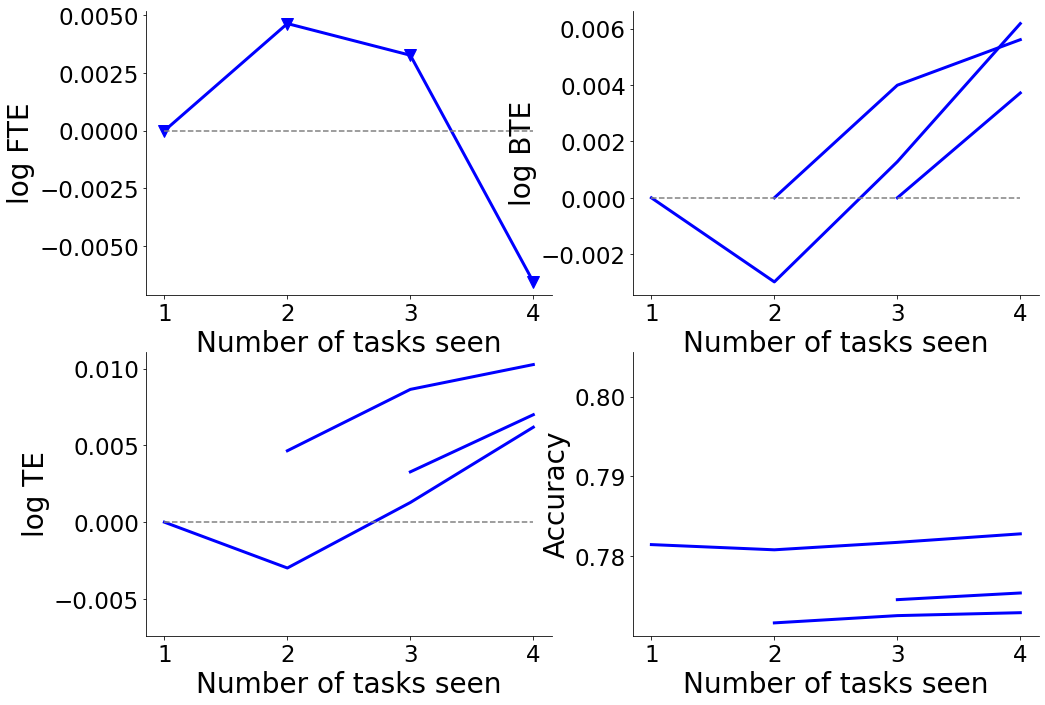

In [14]:
plt.figure()

fig, ax = plt.subplots(2, 2, figsize=(16, 11.5))

fontsize = 28
ticksize = 23
# fte
ax[0][0].plot(
    np.arange(1, num_tasks + 1),
    np.log(fte),
    "blue",
    marker="v",
    markersize=12,
    linewidth=3,
)
ax[0][0].hlines(0, 1, num_tasks, colors="grey", linestyles="dashed", linewidth=1.5)
ax[0][0].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[0][0].set_ylabel("log FTE", fontsize=fontsize)
ax[0][0].tick_params(labelsize=ticksize)
right_side = ax[0][0].spines["right"]
right_side.set_visible(False)
top_side = ax[0][0].spines["top"]
top_side.set_visible(False)
# bte
for t in range(num_tasks):
    ax[0][1].plot(
        np.arange(t + 1, num_tasks + 1), np.log(np.array(bte[t])), "blue", linewidth=3
    )
ax[0][1].hlines(0, 1, num_tasks, colors="grey", linestyles="dashed", linewidth=1.5)
ax[0][1].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[0][1].set_ylabel("log BTE", fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
right_side = ax[0][1].spines["right"]
right_side.set_visible(False)
top_side = ax[0][1].spines["top"]
top_side.set_visible(False)
# te
for t in range(num_tasks):
    ax[1][0].plot(
        np.arange(t + 1, num_tasks + 1), np.log(np.array(te[t])), "blue", linewidth=3
    )
ax[1][0].hlines(0, 1, num_tasks, colors="grey", linestyles="dashed", linewidth=1.5)
ax[1][0].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[1][0].set_ylabel("log TE", fontsize=fontsize)
ax[1][0].tick_params(labelsize=ticksize)

right_side = ax[1][0].spines["right"]
right_side.set_visible(False)
top_side = ax[1][0].spines["top"]
top_side.set_visible(False)
# accuracy
for t in range(num_tasks):
    ax[1][1].plot(
        np.arange(t + 1, num_tasks + 1),
        np.array(mean_accuracies[t, t:-1]),
        "blue",
        linewidth=3,
    )
ax[1][1].set_xlabel("Number of tasks seen", fontsize=fontsize)
ax[1][1].set_ylabel("Accuracy", fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)

right_side = ax[1][1].spines["right"]
right_side.set_visible(False)
top_side = ax[1][1].spines["top"]
top_side.set_visible(False)

In [ ]:
prediction = learner.predict(X_test, task_id=0).reshape(Y_test.shape)

Text(0.5, 1.0, 'Predicted Mask (Dice: 0.9058)')

<Figure size 432x288 with 0 Axes>

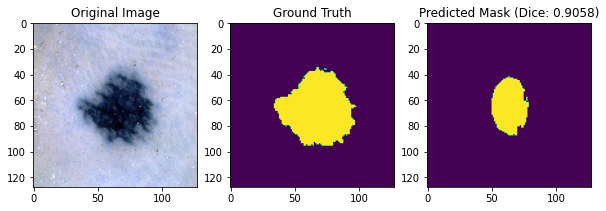

In [64]:
plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(10, 30))
ax[0].imshow(X_test[0])
ax[0].set_title("Original Image")
ax[1].imshow(Y_test[0])
ax[1].set_title("Ground Truth")
ax[2].imshow(prediction[0])
ax[2].set_title("Predicted Mask (Dice: {:.4f})".format(dice(Y_test[0], prediction[0])))